# GWAS Quality Control using PLINK


One of the most important aspects of a Genome Wide Analysis Studies (GWAS) is to do thorough Quality control (QC) of the data before analysing it. The QC of GWAS goes through various steps (see figure below), and we will illustrate some of them in this tutorial.

<img src="img/main_QC_GWAS.png" alt="QC" width="300">

## How to make this notebook work

* In this notebook we will use both the `command line bash` commands and `R` to setup the file folders.
* Having to shift between two languages, you need to choose a kernel every time we shift from one language to another. A kernel contains a programming language and the necessary packages to run the course material. To choose a kernel, go on the menu on the top of the page and select `Kernel --> Change Kernel`, and then select the preferred one. We will shift between two kernels, and along the code in this notebook you will see a picture telling you to change kernel. The two pictures are below:

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

* You can run the code in each cell by clicking on the run cell sign in the toolbar, or simply by pressing <kbd>Shift</kbd>+<kbd>Enter</kbd>. When the code is done running, a small green check sign will appear on the left side.
* You need to run the cells in sequential order to execute the analysis. Please do not run a cell until the one above is done running, and do not skip any cells
* The code goes along with textual descriptions to help you understand what happens. Please try not to focus on understanding the code itself in too much detail - but rather try to focus on the explanations and on the output of the commands 
*   You can create new code cells by pressing `+` in the Menu bar above or by pressing <kbd>B</kbd> after you select a cell. 

## Background material

- [Anderson et al 2010](https://www.nature.com/articles/nprot.2010.116), review on data quality control for GWAS studies (on which this tutorial is based).

- A [video lecture](https://www.youtube.com/watch?v=2R5fmWxb9I4) on quality control for GWAS.

- [Uffelmann et al 2021](https://www.nature.com/articles/s43586-021-00056-9), a review on GWAS methods.



## Software:

We will be using `plink`, a comprehensive tool for handling and analyzing SNP data that can perform many different kinds of analyses. Check the documentation [here](https://www.cog-genomics.org/plink/1.9/)
If you want info about a specific command you can also use help command:
```
plink --help <name_of_command>
```

## Data:

In this practical, we will go through the steps in performing quality control (QC) of genotype data from a simulated genome-wide association study of 1000 cases and 1000 controls, typed for 317,503 autosomal and X chromosome SNPs.

We will link to the following folder, which contains the necessary files in `.bed, .bim, .fam` formats, and make the `Results` folder:

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel

In [1]:
ln -s ../../Data/GWAS/GWAS_QC_data/
mkdir -p Results

ln: failed to create symbolic link './GWAS_QC_data': File exists


# Sample QC

We will begin by performing sample QC, including calculation of call rates, heterozygosity, and sex discordance.  We will then perform SNP QC, including calculation of call rates and deviation from Hardy-Weinberg equilibrium. 

The following command will infer the sex of the sample by looking at the mean homozygosity rate across X-chromosome markers and compares it to the sex stated in the `.fam` file.

In [2]:
plink --bfile GWAS_QC_data/GWA-data --check-sex --out Results/GWA-QC

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC.log.
Options in effect:
  --bfile GWAS_QC_data/GWA-data
  --check-sex
  --out Results/GWA-QC

385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
2000 people (997 males, 1003 females) loaded from .fam.
2000 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2000 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
commands treat these as missing.
Total genotyping rate is 0.985682.
317503 variants and 2000 people pass filters and QC.
Among remaining phenotypes, 1023 are cases and 977 are c



**Q1)** Take a look at the output file `GWA-data.sexcheck`. How many problematic samples are there?

Problematic samples can be removed by copying the family ID (FID) and individual ID (IID) of the samples into a text file and using the `remove` command. Below, we use `head` to see how the file `GWA-data.sexcheck` is structured. The column `STATUS` might contain the indicator we need to filter out problematic samples, so we apply `grep -v` to see which lines do not contain the string `OK`. Then we write those lines in the file `wrong_sex.txt` so we can apply filtering with `plink` afterwards.

In [3]:
#preview of the file
head Results/GWA-QC.sexcheck

 FID  IID       PEDSEX       SNPSEX       STATUS            F
   1    1            1            1           OK       0.9552
   2    2            1            1           OK       0.9997
   3    3            1            1           OK       0.9935
   4    4            1            1           OK            1
   5    5            2            2           OK     0.007004
   6    6            2            2           OK     0.007528
   7    7            2            2           OK    -0.003711
   8    8            2            2           OK     0.007389
   9    9            2            2           OK    -0.009868


In [4]:
#check lines without "OK"
grep -v "OK" Results/GWA-QC.sexcheck

 FID  IID       PEDSEX       SNPSEX       STATUS            F
 772  772            2            0      PROBLEM       0.3084
 853  853            2            0      PROBLEM       0.3666
1920 1920            2            0      PROBLEM       0.4066


In [7]:
#put those lines in a file
grep -v "OK" Results/GWA-QC.sexcheck > Results/wrong_sex.txt
cat Results/wrong_sex.txt

 FID  IID       PEDSEX       SNPSEX       STATUS            F
 772  772            2            0      PROBLEM       0.3084
 853  853            2            0      PROBLEM       0.3666
1920 1920            2            0      PROBLEM       0.4066


Alternatively, one can ose the `awk` command to print the elements in the fifth column of the file (`awk '{if (NR > 1) print $5}'`), and then sort those elements alphabetically (`sort -k1,1`) and print their unique occurrences (option `-u`), so that it can be decided which use of `grep -v` makes sense. We can see there are only two possible values of `STATUS`: `OK`, `PROBLEM`.

In [8]:
awk '{if (NR > 1) print $5}' Results/GWA-QC.sexcheck | sort -k1,1 -u

OK
PROBLEM


Now we run `plink` with the command `--remove` to filter out the problematic samples. The `--out` option in plink specifies the prefix of the output files that plink generates. And when we use the `--make-bed` command we are writing the output to the specified prefix. In this case, all our output files will have the prefix: `GWA-QC`.

In [9]:
plink --bfile GWAS_QC_data/GWA-data --remove Results/wrong_sex.txt --make-bed --out Results/GWA-QC_sflt

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC_sflt.log.
Options in effect:
  --bfile GWAS_QC_data/GWA-data
  --make-bed
  --out Results/GWA-QC_sflt
  --remove Results/wrong_sex.txt

385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
2000 people (997 males, 1003 females) loaded from .fam.
2000 phenotype values loaded from .fam.
--remove: 1997 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1997 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
many commands treat these as missing.
Total genotyping rate in remaining samples is 0.985924.
317503 v

**Q2)** Each time a plink command is run it writes a summary to a log file (the file name ends with `.log`). Look at the log file after removing the problematic individuals. How many cases and controls are left in the data set?

## Identification of individuals with elevated missing data rates or outlying heterozygosity rate

The following `plink` command will create the files `GWA-QC.imiss` and `GWA-QC.lmiss`.  The fourth column in the file `GWA-data.imiss` (N_MISS) denotes the number of missing SNPs and the sixth column (F_MISS) denotes the proportion of missing SNPs per individual.

In [11]:
plink --bfile Results/GWA-QC_sflt --missing --out Results/GWA-QC_sflt

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC_sflt.log.
Options in effect:
  --bfile Results/GWA-QC_sflt
  --missing
  --out Results/GWA-QC_sflt

385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
1997 people (997 males, 1000 females) loaded from .fam.
1997 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1997 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
many commands treat these as missing.
Total genotyping rate is 0.985924.
--missing: Sample missing data report written to Results/GWA-QC_sflt.imiss, and
variant-based miss

Now with `plink` we create the file `GWA-data.het`, in which the third column denotes the observed number of homozygous genotypes `O(Hom)` and the fifth column denotes the number of non-missing genotypes `N(NM)` per individual.

You can calculate the observed heterozygosity rate per individual using the formula:

$Het = \frac{N(NM) − O(Hom)}{N(NM)}$

In [14]:
plink --bfile Results/GWA-QC_sflt --het --out Results/GWA-QC_sflt

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC_sflt.log.
Options in effect:
  --bfile Results/GWA-QC_sflt
  --het
  --out Results/GWA-QC_sflt

385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
1997 people (997 males, 1000 females) loaded from .fam.
1997 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1997 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
many commands treat these as missing.
Total genotyping rate is 0.985924.
317503 variants and 1997 people pass filters and QC.
Among remaining phenotypes, 1022 are cases and 97

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

By running this I get the mean of number of missing genotypes and missing frequencies for each sample. I also compute the observed heterozygosity on each individual. Then, I plot these results, outlying extreme values on both variables, i.e missing frequency greater than 3% and heterozygosity lower or greaater than 3 standard deviations from the mean.
A high proportion of missing genotypes is indicative of low DNA quality or concentration, while higher or lower proportion of heterozygotes is indicative of contamination or inbreeding, respectively.

[1] 4469.217

[1] 0.01407614

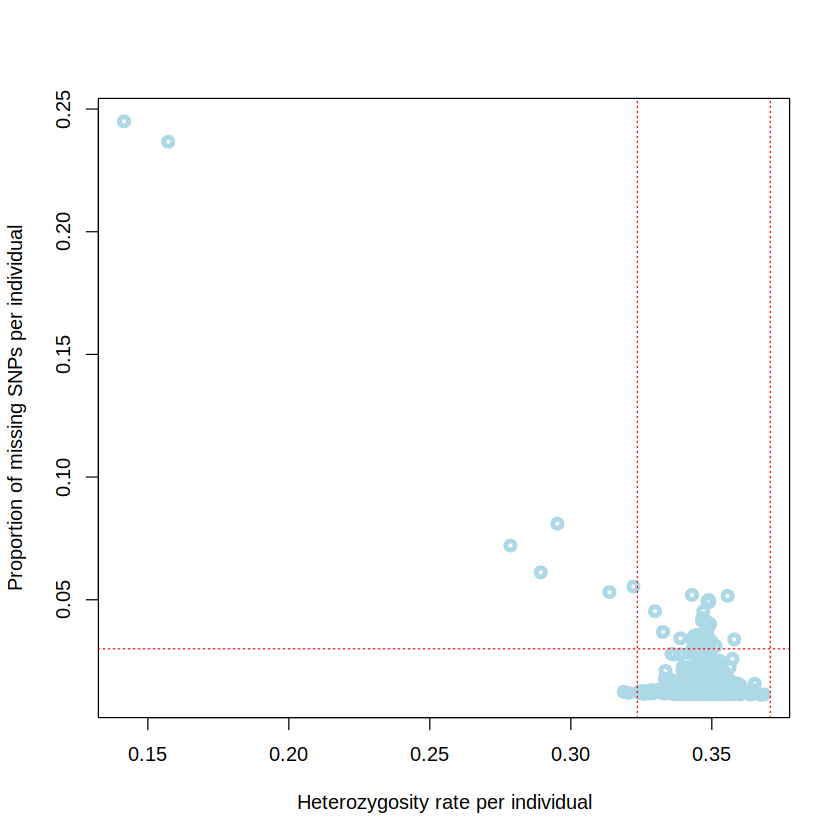

In [2]:
Imiss = read.table('Results/GWA-QC_sflt.imiss', header = TRUE)
mean(Imiss$N_MISS)
mean(Imiss$F_MISS)

het = read.table('Results/GWA-QC_sflt.het', header = T)
het$het_cal = (het$N.NM. - het$O.HOM.)/ het$N.NM.
mean_het = mean(het$het_cal)
sd_het = sd(het$het_cal)

plot(x = het$het_cal,y = Imiss$F_MISS, lwd =4, col = 'light blue', xlab = 'Heterozygosity rate per individual', ylab = 'Proportion of missing SNPs per individual')
abline(h = 0.03, col = 'red', lty = 3)
abline(v = mean_het + 3*sd_het, col = 'red', lty = 3)
abline(v = mean_het - 3*sd_het, col = 'red', lty = 3)

Proceed to filter samples based on these criteria:

In [3]:
right_tail = mean_het + 3*sd(het$het_cal)
left_tail =  mean_het - 3*sd(het$het_cal)

filtering = cbind(Imiss, het)
outlier_ind = subset(filtering, filtering$F_MISS >= 0.03 | filtering$het_cal > right_tail | filtering$het_cal < left_tail)

nrow(outlier_ind)

write.table(outlier_ind[,c(1,2)], 'Results/wrong_het_missing_values.txt', col.names = FALSE, row.names = FALSE)

[1] 43

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel

In [1]:
plink --bfile Results/GWA-QC_sflt --remove Results/wrong_het_missing_values.txt --make-bed --out Results/GWA-QC_sflt_hflt_mflt

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC_sflt_hflt_mflt.log.
Options in effect:
  --bfile Results/GWA-QC_sflt
  --make-bed
  --out Results/GWA-QC_sflt_hflt_mflt
  --remove Results/wrong_het_missing_values.txt

385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
1997 people (997 males, 1000 females) loaded from .fam.
1997 phenotype values loaded from .fam.
--remove: 1954 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1954 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Results/GWA-QC_sflt_hflt_mflt.hh ); many commands treat these as miss

After that, you should have the same number of variants and 1954 samples left. You should also see that we have created bed, bim and fam files for `GWA-QC_sflt_mflt_hflt`, containing our filtered dataset.

In [2]:
ls Results/GWA-QC_sflt_hflt_mflt*

Results/GWA-QC_sflt_hflt_mflt.bed  Results/GWA-QC_sflt_hflt_mflt.hh
Results/GWA-QC_sflt_hflt_mflt.bim  Results/GWA-QC_sflt_hflt_mflt.log
Results/GWA-QC_sflt_hflt_mflt.fam


## Identification of duplicated or related individuals
To identify duplicated or related individuals we will calculate the identity by descent (IBD) matrix, indicative of relatedness between individuals or repeated samples, that could bias our GWAS. This works best if it is done on a set of non-correlated SNPs. So first we will “prune” the data and create a list of SNPs where no pair (within a given genomic interval) has an r2 value greater than a given threshold, typically chosen to be 0.2.  This can be done by the `indep-pairwise` command, using 500kb as window size and 5 variants as step size:


In [1]:
plink --bfile Results/GWA-QC_sflt_hflt_mflt --indep-pairwise 500kb 5 0.2 --out Results/GWA-QC_sflt_hflt_mflt
plink --bfile Results/GWA-QC_sflt_hflt_mflt --extract Results/GWA-QC_sflt_hflt_mflt.prune.in --genome --min 0.185 --out Results/GWA-QC_sflt_hflt_mflt
ls -lht Results/

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC_sflt_hflt_mflt.log.
Options in effect:
  --bfile Results/GWA-QC_sflt_hflt_mflt
  --indep-pairwise 500kb 5 0.2
  --out Results/GWA-QC_sflt_hflt_mflt

units.
385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
1954 people (973 males, 981 females) loaded from .fam.
1954 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1954 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Results/GWA-QC_sflt_hflt_mflt.hh ); many commands treat these as missing.
Total genotyping rate is 0.98671.
317503 v

The `--min 0.185` option means that it will only print the calculated IBD if it is above 0.185 (Mean between second-degree relatives:0.25 and third-degree relatives:0.125). The PI_HAT value in column 10 of the output file will be a number between 0 and 1 saying how much of the genome the two individuals share (1 for identical twins, 0.5 for siblings etc.). This command will produce a file called GWA-data_sflt_hflt_mflt.genome .


<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

In `R`, I proceed in analyzing the output file, named `Results/GWA-QC_sflt_hflt_mflt.genome`, to remove a member from each of the pairs that are too closely related from the data set.

In [1]:
ibd = read.table('Results/GWA-QC_sflt_hflt_mflt.genome', header = TRUE)
members = ibd[,1]
members = unique(members)
length(members)
write.table(cbind(members,members), file = 'Results/wrong_ibd.txt', col.names = F, row.names = F)

[1] 14

With these lines of code, I obtain a unique set of 14 samples that show outlying IDB with another sample. Here we are exploiting the fact that FID and IID are the same in our dataset, but we would have to contition on both if that wasn't the case. Back to the command line, I filter out samples in our dataset using this file by running:

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel


In [1]:
plink --bfile Results/GWA-QC_sflt_hflt_mflt --remove Results/wrong_ibd.txt --make-bed --out Results/GWA-QC_sflt_hflt_mflt_iflt

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC_sflt_hflt_mflt_iflt.log.
Options in effect:
  --bfile Results/GWA-QC_sflt_hflt_mflt
  --make-bed
  --out Results/GWA-QC_sflt_hflt_mflt_iflt
  --remove Results/wrong_ibd.txt

385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
1954 people (973 males, 981 females) loaded from .fam.
1954 phenotype values loaded from .fam.
--remove: 1940 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1940 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Results/GWA-QC_sflt_hflt_mflt_iflt.hh ); many commands treat thes

I get a new set of files, containing the same number of variables and the samples that survived the wrong sex, the missing data and ibd filtering. At this point, you should have 1940 samples, 988 cases and 952 controls.

# Variant QC

## SNPs with an excessive missing data rate

We need to re-compute the missing data for each variant, since we filtered some samples. Using the `--missing` command again to generate the `GWA-QC_sflt_hflt_mflt_iflt.lmiss` with the missing data rate for each SNP. I do that by running:

In [2]:
plink --bfile Results/GWA-QC_sflt_hflt_mflt_iflt --missing --out Results/GWA-QC_sflt_hflt_mflt_iflt

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC_sflt_hflt_mflt_iflt.log.
Options in effect:
  --bfile Results/GWA-QC_sflt_hflt_mflt_iflt
  --missing
  --out Results/GWA-QC_sflt_hflt_mflt_iflt

385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
1940 people (965 males, 975 females) loaded from .fam.
1940 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1940 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Results/GWA-QC_sflt_hflt_mflt_iflt.hh ); many commands treat these as missing.
Total genotyping rate is 0.986697.
--missing: Sa

I open `Results/GWA-data_sflt_hflt_mflt_iflt.lmiss` in `R` to plot an histogram of the variant's missing frequency:

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

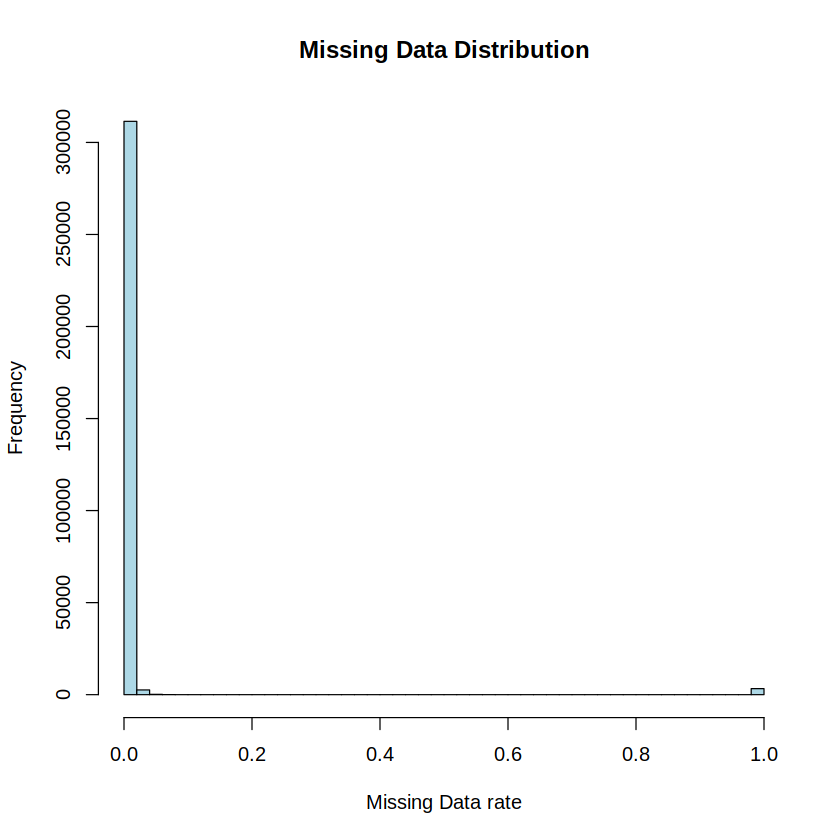

In [1]:
miss_data = read.table('Results/GWA-QC_sflt_hflt_mflt_iflt.lmiss', header = T)
hist(miss_data$F_MISS, breaks = 50, col = 'light blue', main = 'Missing Data Distribution', xlab = 'Missing Data rate')

A lot of care must be taken when filtering variants, since we can lose potential variants associaated with the phenotypic trait. Therefore, we only filter these variants in which the missigness is associated with the phenotype, i.e case or control, so they could be a source of bias in our study.

We use `plink` with the `--test-missing` command to test for association between missingness and case/control status, using Fisher's exact test. It produces a file with `.missing` suffix. We make a list of all the names of all SNPs where the differential missingness p-value is less than 1e-5. The list is saved as `fail-diffmiss-qc.txt`

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel

In [1]:
plink --bfile Results/GWA-QC_sflt_hflt_mflt_iflt --test-missing --out Results/GWA-QC_sflt_hflt_mflt_iflt

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC_sflt_hflt_mflt_iflt.log.
Options in effect:
  --bfile Results/GWA-QC_sflt_hflt_mflt_iflt
  --out Results/GWA-QC_sflt_hflt_mflt_iflt
  --test-missing

385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
1940 people (965 males, 975 females) loaded from .fam.
1940 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1940 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Results/GWA-QC_sflt_hflt_mflt_iflt.hh ); many commands treat these as missing.
Total genotyping rate is 0.986697.
317503 v

This outputs a file named `GWA-data_sflt_mflt_hflt_iflt.missing`. Using `R` and applying a significance criterion of 10e-5, I get significant variants by:


<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

In [1]:
test_missing = read.table('Results/GWA-QC_sflt_hflt_mflt_iflt.missing', header = TRUE)
fail_diffmiss_qc = test_missing[test_missing$P < 10e-5, 2]
write.table(fail_diffmiss_qc, file = 'Results/fail-diffmiss-qc.txt', row.names = F, col.names = F)

Now we can remove low-quality SNPs. In addition to removing SNPs identified with differential call rates between cases and controls, this command removes SNPs with call rate less than 95% with `--geno` option and deviation from HWE (p<1e-5) with the `--hwe` option. It also removes all SNPs with minor allele frequency less than a specified threshold using the `--maf` option.

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel

In [1]:
plink --bfile Results/GWA-QC_sflt_hflt_mflt_iflt --exclude Results/fail-diffmiss-qc.txt --geno 0.05 --hwe 0.00001 --maf 0.01 --make-bed --out Results/GWA-QC_sflt_hflt_mflt_iflt_vflt

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWA-QC_sflt_hflt_mflt_iflt_vflt.log.
Options in effect:
  --bfile Results/GWA-QC_sflt_hflt_mflt_iflt
  --exclude Results/fail-diffmiss-qc.txt
  --geno 0.05
  --hwe 0.00001
  --maf 0.01
  --make-bed
  --out Results/GWA-QC_sflt_hflt_mflt_iflt_vflt

385583 MB RAM detected; reserving 192791 MB for main workspace.
317503 variants loaded from .bim file.
1940 people (965 males, 975 females) loaded from .fam.
1940 phenotype values loaded from .fam.
--exclude: 317503 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1940 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 

Deviations from HWE might indicate genotype error, but we choose a very low siginifcance value, since deviations from HWE might also be a product of selection implying that we could be filtering out variants potentially associated with the phenotypic trait. 
Samples with low allele frequency are also more likely to be miss-calls. Additionally, these variants have low power to be significant associations in the GWAS study due to their low small sample size.

After all filtering, you should be left with:
- 313896 variants.
- 1940 people (988 cases and 952 controls).